In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.8.0+cpu
False


In [3]:
from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
from sklearn.metrics import accuracy_score


In [4]:
dataset = load_dataset("dair-ai/emotion")
label_names = dataset["train"].features["label"].names
num_labels = len(label_names)

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

In [7]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [8]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [9]:
import accelerate
import transformers

print(f"Accelerate version: {accelerate.__version__}")
# This must be >= 0.26.0

Accelerate version: 1.12.0


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\syedr\AppData\Local\Temp\ipykernel_1996\677695135.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [1]:
import torch
print(torch.cuda.is_available())
# MUST print: True

print(torch.cuda.get_device_name(0))
# Should print: NVIDIA GeForce GTX 1060 with Max-Q Design

True
NVIDIA GeForce GTX 1060 with Max-Q Design


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.250900,0.208305,0.924500
2,0.149400,0.178107,0.932500
3,0.094800,0.158971,0.939500


TrainOutput(global_step=3000, training_loss=0.24280227533976237, metrics={'train_runtime': 999.8231, 'train_samples_per_second': 48.008, 'train_steps_per_second': 3.001, 'total_flos': 1589722177536000.0, 'train_loss': 0.24280227533976237, 'epoch': 3.0})

In [16]:
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.17777343094348907,
 'eval_accuracy': 0.9255,
 'eval_runtime': 12.4998,
 'eval_samples_per_second': 160.003,
 'eval_steps_per_second': 10.0,
 'epoch': 3.0}

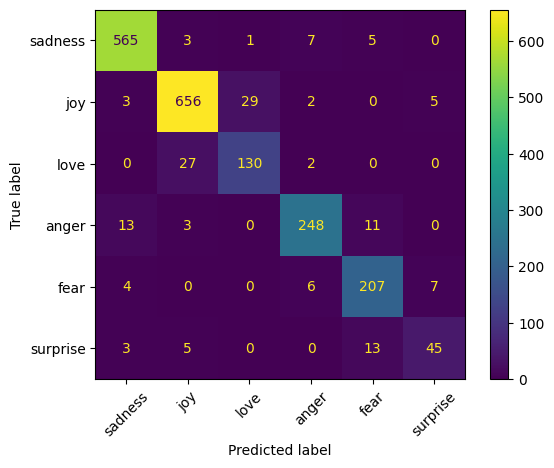

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(tokenized_dataset["test"])
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(xticks_rotation=45)

In [20]:
trainer.save_model("./emotion_model")
tokenizer.save_pretrained("./emotion_model")

('./emotion_model\\tokenizer_config.json',
 './emotion_model\\special_tokens_map.json',
 './emotion_model\\vocab.txt',
 './emotion_model\\added_tokens.json',
 './emotion_model\\tokenizer.json')